In [2]:
import numpy as np 
import pandas as pd 
import os
import tensorflow as tf

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from PIL import Image

In [3]:
X = []
Y = []

for i in tqdm(glob('/kaggle/input/mrl-dataset/train/Open_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(1)
    
for i in tqdm(glob('/kaggle/input/mrl-dataset/train/Closed_Eyes/*')):
    temp = np.array(Image.open(i).resize((64,64)))
    X.append(temp)
    Y.append(0)    




100%|██████████| 2000/2000 [00:05<00:00, 334.37it/s]


In [4]:
X = np.array(X)
X = X/255.0
Y = np.array(Y)

In [5]:
X = np.expand_dims(X,-1)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, BatchNormalization, MaxPooling2D,Dropout, Flatten

model = tf.keras.models.Sequential([
      Input(shape=(64, 64, 1)),

      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu'),
      Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
      Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', use_bias=False),
      BatchNormalization(),
      MaxPooling2D(strides = 2),
      Dropout(0.3),

      Flatten(),
      Dense(units  = 256, activation = 'relu', use_bias=False),
      BatchNormalization(),

      Dense(units = 128, use_bias=False, activation = 'relu'),

      Dense(units = 84, use_bias=False, activation = 'relu'),
      BatchNormalization(),
      Dropout(0.3),

      Dense(units = 1, activation = 'sigmoid')
  ])

In [8]:
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [9]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='bestModel.h5',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose =1)
model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=callback)

Epoch 1/30
67/67 [==============================] - 8s 13ms/step - loss: 0.1296 - accuracy: 0.9552 - val_loss: 0.7488 - val_accuracy: 0.5187

Epoch 00001: val_loss improved from inf to 0.74878, saving model to bestModel.h5
Epoch 2/30
67/67 [==============================] - 1s 8ms/step - loss: 0.0404 - accuracy: 0.9851 - val_loss: 1.3953 - val_accuracy: 0.5187

Epoch 00002: val_loss did not improve from 0.74878
Epoch 3/30
67/67 [==============================] - 1s 8ms/step - loss: 0.0374 - accuracy: 0.9907 - val_loss: 0.2809 - val_accuracy: 0.9123

Epoch 00003: val_loss improved from 0.74878 to 0.28086, saving model to bestModel.h5
Epoch 4/30
67/67 [==============================] - 1s 8ms/step - loss: 0.0163 - accuracy: 0.9953 - val_loss: 0.8363 - val_accuracy: 0.6455

Epoch 00004: val_loss did not improve from 0.28086
Epoch 5/30
67/67 [==============================] - 1s 9ms/step - loss: 0.0171 - accuracy: 0.9939 - val_loss: 0.0906 - val_accuracy: 0.9795

Epoch 00005: val_loss impr

In [10]:
model.evaluate(x_test, y_test)

42/42 [==============================] - 0s 4ms/step - loss: 5.1532 - accuracy: 0.5212


[5.153183460235596, 0.521212100982666]

In [11]:
from keras.models import load_model
best_model = load_model('/kaggle/working/bestModel.h5')
best_model.evaluate(x_test, y_test)

42/42 [==============================] - 0s 4ms/step - loss: 0.0042 - accuracy: 0.9992


[0.004153834190219641, 0.9992424249649048]

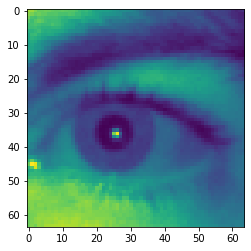

Open


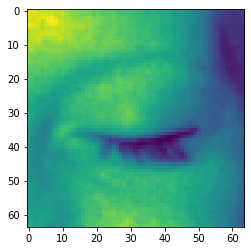

Closed


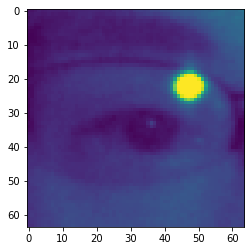

Open


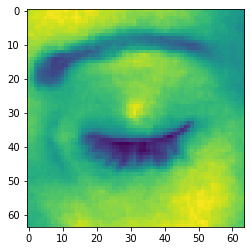

Closed


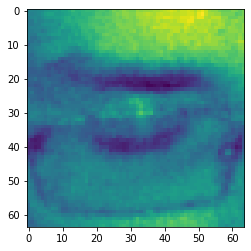

Closed


In [12]:
for i in x_test[0:5]:
    result = best_model.predict(np.expand_dims(i,0))
    plt.imshow(i)
    plt.show()
    
    if result > 0.5:
        print('Open')
    else:
        print("Closed")
    

Text(0.5, 24.0, 'Actual')

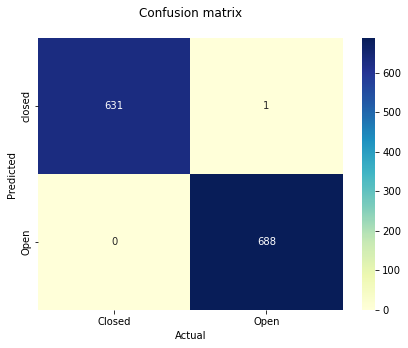

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_model.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['closed', 'Open'], columns=['Closed', 'Open'])
plt.subplot(121)
plt.title("Confusion matrix\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")